In [1]:
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%load_ext autoreload
%autoreload 2

<H3> Select experiment type

In [2]:
#@title Select which experiment you wish to perform inference on: { run: "auto" }
experiment_type = 'ffhq_encode' #@param ['ffhq_encode', 'ffhq_frontalize', 'celebs_sketch_to_face', 'celebs_seg_to_face', 'celebs_super_resolution', 'toonify']

In [3]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "./pretrained_models/psp_ffhq_encode.pt",
        "image_path": "./notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
}

In [4]:
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

<H3> Load model

In [53]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')

In [54]:
opts = ckpt['opts']

In [55]:
# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

In [56]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading pSp from checkpoint: ./pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


In [59]:
pprint.pprint(opts)

Namespace(batch_size=8, board_interval=50, checkpoint_path='./pretrained_models/psp_ffhq_encode.pt', dataset_type='ffhq_encode', device='cuda:0', encoder_type='GradualStyleEncoder', exp_dir='', id_lambda=0.1, image_interval=100, input_nc=3, l2_lambda=1.0, l2_lambda_crop=0, label_nc=0, learn_in_w=False, learning_rate=0.0001, lpips_lambda=0.8, lpips_lambda_crop=0, max_steps=300000, n_styles=18, optim_name='ranger', output_size=1024, resize_factors=None, save_interval=1000, start_from_latent_avg=True, stylegan_weights='', test_batch_size=8, test_workers=2, train_decoder=False, val_interval=2500, w_norm_lambda=0, workers=8)


<H3> Visualize input

In [10]:
image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
original_image = Image.open(image_path)
if opts.label_nc == 0:
    original_image = original_image.convert("RGB")
else:
    original_image = original_image.convert("L")

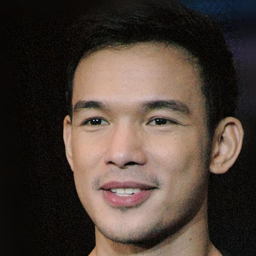

In [11]:
original_image.resize((256, 256))

<H3> Align image </H3>

Note: in this notebook we'll run alignment on the input image for all tasks except for celebs_sketch_to_face and celebs_seg_to_face. That is, only for tasks with real images as inputs. However, all of our applications assume the input has been pre-aligned!

In [12]:
def run_alignment(image_path):
    import dlib
    from scripts.align_all_parallel import align_face
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image

In [13]:
# if experiment_type not in ["celebs_sketch_to_face", "celebs_seg_to_face"]:
#     input_image = run_alignment(image_path)
# else:
#     input_image = original_image

In [14]:
input_image = original_image

<H3> Perform inference

In [15]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

In [16]:
def run_on_batch(inputs, net, latent_mask=None):
    if latent_mask == None:
#         result_batch = net(inputs.to("cuda").float(), randomize_noise=False)
        result_batch = net(inputs.to("cuda"), randomize_noise=False, return_latents=True) 
        
#         print(result_batch[0].shape)
#         print(result_batch[1].shape)
#         print(result_batch)       
    else:
        result_batch = []
        for image_idx, input_image in enumerate(inputs):
            # get latent vector to inject into our input image
            vec_to_inject = np.random.randn(1, 512).astype('float32')
            _, latent_to_inject = net(torch.from_numpy(vec_to_inject).to("cuda"),
                                      input_code=True,
                                      return_latents=True)
            
            # get output image with injected style vector
            res = net(input_image.unsqueeze(0).to("cuda").float(),
                      latent_mask=latent_mask,
                      inject_latent=latent_to_inject)
            result_batch.append(res)
        result_batch = torch.cat(result_batch, dim=0)
        
    return result_batch

In [17]:
latent_mask = None

with torch.no_grad():
    tic = time.time()
    result_image, result_vector = run_on_batch(transformed_image.unsqueeze(0), net, latent_mask)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 1.9390 seconds.


In [18]:
result_vector

tensor([[[  0.0935,   1.5912,  -0.9909,  ...,   2.0717,   2.5438,  -3.1086],
         [ -1.6375,  -2.0287,  -0.4786,  ...,   3.4334,   0.1381,  -0.9722],
         [  9.0319, -14.2336,  23.0338,  ...,   0.1906,  -6.8802,   2.4847],
         ...,
         [ -2.6861,   0.6338,  -0.4981,  ...,  -2.4878,   0.7556,   0.2389],
         [  0.1576,   0.3264,   0.9851,  ...,  -0.7497,  -1.1992,  -0.2423],
         [ -0.6562,  -0.4595,   0.1784,  ...,   0.3889,   0.3129,  -0.1037]]],
       device='cuda:0')

In [19]:
result_image

tensor([[[[-0.8467, -0.8780, -0.8838,  ..., -0.7358, -0.7070, -0.6577],
          [-0.8809, -0.8896, -0.8730,  ..., -0.7701, -0.7272, -0.7230],
          [-0.8970, -0.8867, -0.8666,  ..., -0.7665, -0.7691, -0.7908],
          ...,
          [-0.8978, -0.9089, -0.9069,  ..., -0.8325, -0.8395, -0.8536],
          [-0.8900, -0.9071, -0.9106,  ..., -0.8124, -0.8043, -0.8225],
          [-0.8987, -0.9076, -0.9118,  ..., -0.8572, -0.8352, -0.7850]],

         [[-0.8681, -0.8958, -0.8988,  ..., -0.7423, -0.7239, -0.6728],
          [-0.8994, -0.9129, -0.8946,  ..., -0.7691, -0.7391, -0.7187],
          [-0.9132, -0.9029, -0.8841,  ..., -0.7719, -0.7741, -0.7737],
          ...,
          [-0.9117, -0.9156, -0.9087,  ..., -0.8371, -0.8536, -0.8354],
          [-0.9085, -0.9193, -0.9200,  ..., -0.8170, -0.8181, -0.8089],
          [-0.9135, -0.9191, -0.9161,  ..., -0.8502, -0.8245, -0.7691]],

         [[-0.8378, -0.8780, -0.8867,  ..., -0.6885, -0.6702, -0.6211],
          [-0.8842, -0.9004, -

<H3> Visualize inference

In [20]:
input_vis_image = log_input_image(transformed_image, opts)
output_image = tensor2im(result_image[0])

In [21]:
if experiment_type == "celebs_super_resolution":
    res = np.concatenate([np.array(input_image.resize((256, 256))),
                          np.array(input_vis_image.resize((256, 256))),
                          np.array(output_image.resize((256, 256)))], axis=1)
else:
    res = np.concatenate([np.array(input_vis_image.resize((256, 256))),
                          np.array(output_image.resize((256, 256)))], axis=1)

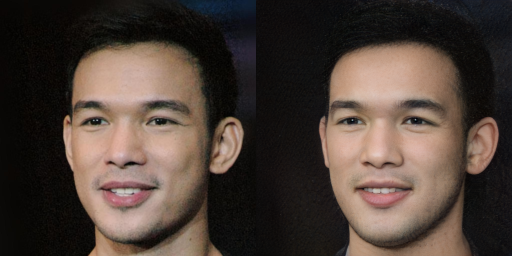

In [22]:
res_image = Image.fromarray(res)
res_image

<H3> Load styleGAN2 feature vectors

In [23]:
age_vector = np.load('./stylegan2directions/age.npy')

In [24]:
age_vector.shape

(18, 512)

<H3> Inference with loaded image

In [25]:
image_path1 = './inversion_images/barak_obama.jpg'

original_image1 = Image.open(image_path1)
original_image1 = original_image1.convert("RGB")
original_image1.resize((256, 256))

input_image1 = original_image1

img_transforms = EXPERIMENT_ARGS['transform']
transformed_image1 = img_transforms(input_image1)

with torch.no_grad():
    tic = time.time()
    result_image1, result_vector1 = run_on_batch(transformed_image1.unsqueeze(0), net, latent_mask)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 0.0890 seconds.


In [26]:
result_image1.shape

torch.Size([1, 3, 256, 256])

In [27]:
input_vis_image1 = log_input_image(transformed_image1, opts)
output_image1 = tensor2im(result_image1[0])

print(result_image1.shape)

torch.Size([1, 3, 256, 256])


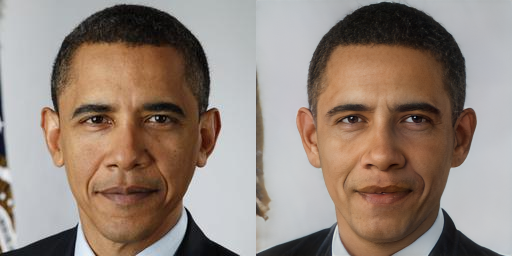

In [28]:
res = np.concatenate([np.array(input_vis_image1.resize((256, 256))),
                          np.array(output_image1.resize((256, 256)))], axis=1)

res_image1 = Image.fromarray(res)
res_image1

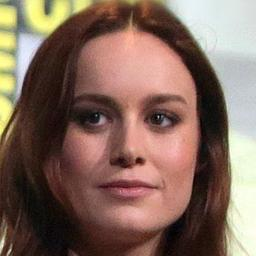

In [29]:
image_path2 = './inversion_images/brie_larson.jpg'

original_image2 = Image.open(image_path2)
original_image2 = original_image2.convert("RGB")
original_image2.resize((256, 256))


In [30]:
input_image2 = original_image2

img_transforms = EXPERIMENT_ARGS['transform']
transformed_image2 = img_transforms(input_image2)

with torch.no_grad():
    tic = time.time()
    result_image2, result_vector2 = run_on_batch(transformed_image2.unsqueeze(0), net, latent_mask)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 0.0930 seconds.


In [31]:
input_vis_image2 = log_input_image(transformed_image2, opts)
output_image2 = tensor2im(result_image2[0])

print(result_image2.shape)

torch.Size([1, 3, 256, 256])


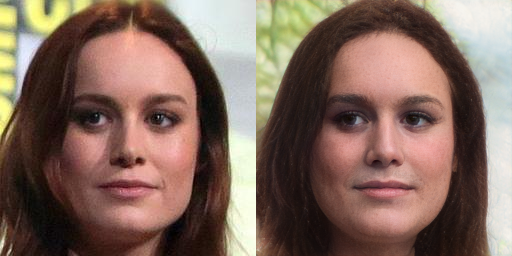

In [32]:
res = np.concatenate([np.array(input_vis_image2.resize((256, 256))),
                          np.array(output_image2.resize((256, 256)))], axis=1)

res_image2 = Image.fromarray(res)
res_image2

In [33]:
print(result_vector1)
print(result_vector2)
print(result_vector1.shape)
print(result_vector2.shape)

tensor([[[ -0.8954,   4.0070,  -2.0415,  ...,   2.6891,   3.7703,  -2.2991],
         [ -1.2898,  -2.1388,  -0.2095,  ...,   2.9460,  -0.6196,  -0.4184],
         [  8.5836, -10.7548,  23.0558,  ...,   0.5954,  -3.1930,   2.1867],
         ...,
         [ -0.9092,   0.0430,  -0.5918,  ...,  -1.5311,   0.7448,   0.0791],
         [  0.1007,   0.2504,   0.5916,  ...,  -0.6312,  -0.9327,  -0.3603],
         [ -0.9647,  -0.2226,   0.5074,  ...,   0.0855,  -0.0605,   0.2624]]],
       device='cuda:0')
tensor([[[-1.2578e+00,  3.9988e+00, -1.3084e+00,  ...,  2.2868e+00,
           3.8782e+00, -1.6631e+00],
         [-1.3139e+00, -1.5621e+00, -1.3567e-01,  ...,  2.7896e+00,
          -1.3847e+00, -9.7998e-01],
         [ 7.4996e+00, -1.3322e+01,  2.4545e+01,  ...,  5.8142e+00,
          -1.9984e+00,  2.2142e+00],
         ...,
         [-2.2082e+00,  2.1262e-02, -1.5638e+00,  ..., -1.5012e+00,
           5.5021e-01, -4.1957e-01],
         [-2.4084e-01,  4.3911e-01,  5.5194e-01,  ..., -2.9415e-

In [34]:
from models.stylegan2.model import Generator

def get_keys(d, name):
    if 'state_dict' in d:
        d = d['state_dict']
    d_filt = {k[len(name) + 1:]: v for k, v in d.items()
              if k[:len(name)] == name}
    return d_filt

decoder = Generator(1024, 512, 8).to("cuda")

print('Loading pSp from checkpoint: {}'.format(opts.checkpoint_path))
ckpt = torch.load(opts.checkpoint_path, map_location='cpu')
decoder.load_state_dict(get_keys(ckpt, 'decoder'), strict=True)

Loading pSp from checkpoint: ./pretrained_models/psp_ffhq_encode.pt


<All keys matched successfully>

In [35]:
mix_vector = (result_vector1 + result_vector2) / 2 
print(mix_vector.shape)

mix_result = decoder([mix_vector.to("cuda")], input_is_latent=True, randomize_noise=False, return_latents=False)[0]
print(mix_result.shape)

torch.Size([1, 18, 512])
torch.Size([1, 3, 1024, 1024])


<PIL.Image.Image image mode=RGB size=1024x1024 at 0x21BF42BFB50>


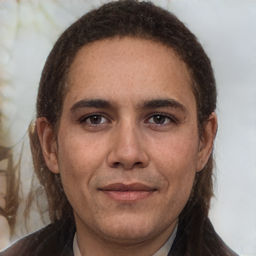

In [36]:
output_mix = tensor2im(mix_result[0])
print(output_mix)
mix = np.array(output_mix.resize((256, 256)))

res_image3 = Image.fromarray(mix)
res_image3

<H3> Moving to feature direction

In [37]:
age_vector = np.load('./stylegan2directions/age.npy')
print(age_vector.shape)

degree = 5

(18, 512)


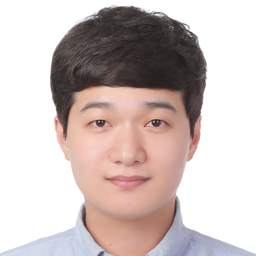

In [38]:
original_image_path = './notebooks/images/Dongyun.jpg'

original_image = Image.open(original_image_path)
original_image = original_image.convert("RGB")
original_image.resize((256, 256))

In [39]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(original_image)

ori_image, ori_vector = run_on_batch(transformed_image.unsqueeze(0), net, latent_mask)

In [40]:
old_vector = ori_vector + torch.from_numpy(age_vector.astype(np.float32)).to("cuda") * degree
young_vector = ori_vector - torch.from_numpy(age_vector.astype(np.float32)).to("cuda") * degree
print(old_vector.shape)

torch.Size([1, 18, 512])


In [41]:
old_result = decoder([old_vector.to("cuda")], input_is_latent=True, randomize_noise=False, return_latents=False)[0]
young_result = decoder([young_vector.to("cuda")], input_is_latent=True, randomize_noise=False, return_latents=False)[0]
print(old_result.shape)

torch.Size([1, 3, 1024, 1024])


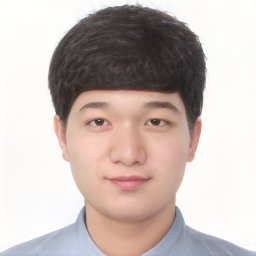

In [49]:
ori_image = tensor2im(ori_image[0])

ori_image.resize((256,256))

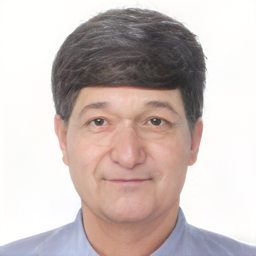

In [50]:
old_image = tensor2im(old_result[0])

old_image.resize((256,256))

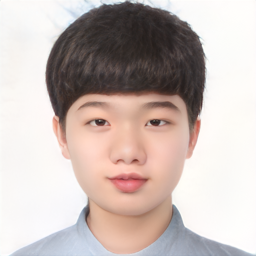

In [51]:
young_image = tensor2im(young_result[0])

young_image.resize((256,256))

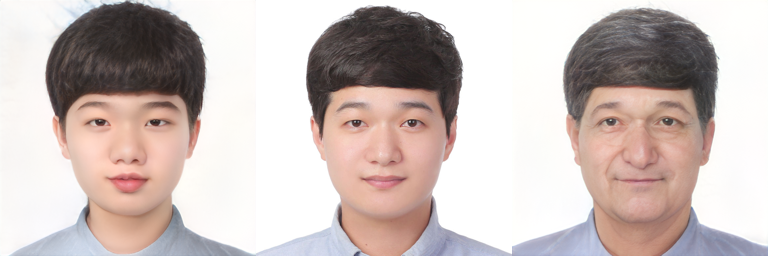

In [61]:
res = np.concatenate([np.array(young_image.resize((256, 256))),
                      np.array(original_image.resize((256,256))),
                          np.array(old_image.resize((256, 256)))], axis=1)

res_image = Image.fromarray(res)
res_image